<a href="https://colab.research.google.com/github/efraimam/introToDLAss1/blob/yuval/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1. Music Century Classification

**Deadline**: Sunday, April 4th, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 



In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [73]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [74]:
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [75]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [76]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [77]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [78]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Answer:
# Usualy, differnt songs from the same artist will have a messure of similarity, therofre having songs from the same artist both on train and test
# may encourage overffiting in our trained model. Moreover, recalling the NN task is identifing the song century, most of the artisit are active in only one century, and so if we use songs from
# the same artist both on train and test we may harm the accuracy results on test when dealing with new songs that were never seen on train.


### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [79]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [80]:
# Answer:
#Since the test dataset is unknown and will be presented to the model for in the inference step,
# dealing with real world application, it cannot be assumed that all the test data will be presented to the model at once.
# Therefore, it is invalid to normalized all the test dataset in advance. 
# Under the reasonable assumption that the test will have similar distribution to the train dataset,
# we can normalize the test dataset with the train mean and std which will be a good estimation for the test mean and std.

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [81]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]
train_size = 50000 #50000
# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[train_size:], train_xs[:train_size]
train_norm_xs, val_norm_xs = train_norm_xs[train_size:], train_norm_xs[:train_size]
train_ts, val_ts           = train_ts[train_size:], train_ts[:train_size]

# Answer:
# Since the test dataset will be introduced to the model only on the inference step,
# we can not evaluate our model and test its accuracy on the test dataset.
# Checking accuracy in the train step is crucial for the evaluation and understanding of the trained model,
# that’s why we take a random small portion from the train dataset which will be used as the validation dataset.
# The validation dataset will not be used for the weight training, instead it will be used to check the model accuracy on data that
# were never introduced to the model for accuracy check in the training step.



## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [82]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [83]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
 
  return sigmoid(X @ w + b)


Test pred:

In [84]:
>>> pred(np.zeros(90), 1, np.ones([2, 90]))

array([0.73105858, 0.73105858])

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [85]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Based On analytical expression from text cell below
  # Dims  
  N, d = X.shape

  phi = y-t 
  dLdw = X.T @ phi / N
  dLdb = np.mean(phi)

  return dLdw, dLdb



**Explenation on Gradients**:




We will use the chain law to find $\frac{d\mathcal{L}}{db}, \frac{d\mathcal{L}}{d\mathbf{w}}$. That is:
$$ \frac{d\mathcal{L}}{db} = \sum_{n=1}^{N}\frac{d\mathcal{L}(\mathbf{y,t})}{dy_n}\frac{dy_n}{db}$$
$$ \frac{d\mathcal{L}}{d\mathbf{w}} = \sum_{n=1}^{N}\frac{d\mathcal{L}(\mathbf{y,t})}{dy_n}\frac{dy_n}{d\mathbf{w}}$$

First we will find $\frac{d\mathcal{L}}{dy_n}$ where the cost function $\mathcal{L}$ is the empirical mean of the cross entropy funcion.
$$ \frac{d\mathcal{L}(\mathbf{y,t})}{dy_n} = \frac{d}{dy_n}\left(\frac{1}{N} \sum_{k=1}^{N}\left(-t_k\log(y_k)-(1-t_k)\log(1-y_k)\right)\right) 
= \frac{y_n-t_n}{Ny_n(1-y_n)}$$

Next we will find $\frac{dy_n}{db}, \frac{dy_n}{d\mathbf{w}}$ using the chain rule agian:
$$ \frac{dy_n}{db} = \sigma'(z_n) \frac{dz_n}{db}$$
$$ \frac{dy_n}{d\mathbf{w}} = \sigma'(z_n) \frac{dz_n}{d\mathbf{w}}$$
where $z_k = \mathbf{w}^T\mathbf{x}_k +b$.

We know that the derivative of Sigmoid function satisfies:
$$ \sigma'(z_n) = \sigma(z_n)(1-\sigma(z_n)) = y_n(1-y_n)$$

Recalling $y_n$:
$$ y_n = \sigma(z_k)$$
The derivites of $z_n$ are:
$$ \frac{dz_n}{db} = 1$$
$$ \frac{dz_n}{d\mathbf{w}} = \mathbf{x}_n$$

Pulgining all together we get:
$$ \frac{d\mathcal{L}}{db} = \sum_{n=1}^{N} \left(\frac{y_n-t_n}{Ny_n(1-y_n)}y_n(1-y_n)\right) =   \frac{1}{N}\sum_{n=1}^{N}y_n-t_n$$

$$ \frac{d\mathcal{L}}{d\mathbf{w}} = \sum_{n=1}^{N} \left(\frac{y_n-t_n}{Ny_n(1-y_n)}y_n(1-y_n)\mathbf{x}_n\right) =   \frac{1}{N}\sum_{n=1}^{N}(y_n-t_n)\mathbf{x}_n$$


By defining $\boldsymbol{\varphi}= \mathbf{y-t}$ and $\mathbf{X} = [\mathbf{x_1},\dots , \mathbf{x}_n]$ , we can write:

$$\frac{d\mathcal{L}}{db} = \frac{1}{N}\boldsymbol{\varphi}^T\mathbf{1} $$ 
$$\frac{d\mathcal{L}}{db} = \frac{1}{N}\mathbf{X}\boldsymbol{\varphi} $$ 




### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [86]:
# Your code goes here

#Data, labels
bs = 100
X = train_norm_xs[:bs,:]
t = train_ts[:bs].flatten()
# Weights for example
w = np.zeros(90)
b = 1
#Create Cost
y = pred(w, b, X)
cost_func = cost(y, t)

#Create values with infinitesimal diff
delta = 1e-6
y_delta = pred(w, b + delta, X)
cost_delta = cost(y_delta, t)

#Create derivetives
_, r1 = derivative_cost(X, y, t)
r2 = (cost_delta - cost_func) / delta

#Prints
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)



The analytical results is - 0.19105857863000486
The algorithm results is -  0.1910586772124745


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [87]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code

#Create values with infinitesimal diff
delta = 1e-6
ei = np.zeros(90); ei[0] = 1
cost_delta = np.array([cost(pred(w + delta * np.roll(ei,i),b,X),t) for i in range(90)])

#Create derivetives
r1, _ = derivative_cost(X, y, t)
r2 = (cost_delta - cost_func) / delta

#Prints
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)
print("Norm Diff - ", np.linalg.norm(r1-r2))

The analytical results is - [-2.11649199e-01 -2.08733952e-02 -3.69623855e-02  5.04527433e-02
 -3.76471495e-02  9.68148633e-02 -6.37978378e-02 -2.38459479e-02
  1.72800249e-02 -3.51873603e-02  5.18420421e-02  5.81311206e-02
  5.12311733e-02  7.73467152e-02  3.91936985e-02  4.33201632e-02
  1.33228627e-02  5.52143215e-02 -3.95551728e-02  2.93020295e-02
 -2.72728213e-02  4.56871222e-02  3.50012742e-02 -3.81186187e-02
  5.91461674e-02 -6.94042398e-03 -3.85251613e-02 -3.64564662e-02
 -4.91181859e-02 -1.79888765e-04  1.56053014e-02  2.83284261e-02
 -7.93320863e-02  8.37688931e-02 -8.53057336e-02  1.43665252e-03
  1.09576364e-01 -9.02929914e-02  4.11417888e-02  3.25112308e-02
  6.46056049e-02 -2.35806176e-02  1.89232183e-02  9.25183396e-02
 -2.73815299e-03  4.87312094e-02 -1.09476867e-02  2.08169083e-02
 -7.46459782e-02 -5.55522956e-02  1.03577926e-01 -3.20708918e-02
 -4.69506001e-02  2.60342547e-02 -4.11367027e-02  1.44800903e-01
 -3.39261413e-02 -4.27422806e-02 -4.11413711e-03 -8.05943054e-

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [88]:
def run_gradient_descent(train_norm_xs, train_ts, val_norm_xs, val_ts, w0, b0, mu=0.1, batch_size=100, max_iters=100, verbose=True):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0
  train_loss_arr = []
  val_loss_arr = []
  val_acc_arr = []
  trian_acc_arr = []
  best_acc = 0.0
  best_b = 0.0
  best_w = 0
  

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_norm_xs))
    train_norm_xs = train_norm_xs[reindex]
    train_ts = train_ts[reindex]
    

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs[i:(i + batch_size)]
      t = train_ts[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      predictions = pred(w, b, X)

      # update w and b
      grad_w, grad_b = derivative_cost(X, predictions, t)
      w = w - mu * grad_w
      b = b - mu * grad_b

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        pred_val = pred(w, b, val_norm_xs)
        pred_train = pred(w, b, X)
        val_cost = cost(pred_val, val_ts)
        val_acc = get_accuracy(pred_val, val_ts)
        train_acc = get_accuracy(pred_train, t)
        train_loss = cost(pred_train, t)

        train_loss_arr.append(train_loss)
        trian_acc_arr.append(train_acc)
        val_loss_arr.append(val_cost)
        val_acc_arr.append(val_acc)

        if val_acc >= best_acc:
          best_b = b
          best_w = w
          best_acc = val_acc


        if verbose:
          print("Iter %4d. [Train Loss %f, Val Loss %f, Train Acc %.0f%%, Val Acc %.0f%%]" % (
                  iter, train_loss, val_cost, train_acc*100, val_acc * 100))
        else:
          if (iter % (max_iters//4) == 0):
            print("Iter %4d. [Train Loss %f, Val Loss %f, Train Acc %.0f%%, Val Acc %.0f%%]" % (
                  iter, train_loss, val_cost, train_acc*100, val_acc * 100))


          

      if iter >= max_iters:
        break


  analysis_dict = {'Train_Loss': np.array(train_loss_arr),
                  'Val_Loss':np.array(val_loss_arr),
                  'Train_acc':np.array(trian_acc_arr),
                  'Val_acc':np.array(val_acc_arr),
                   'best_b': best_b,
                   'best_w': best_w,
                   'best_acc': best_acc}

        
  return w, b, analysis_dict



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

In [89]:
w0 = np.zeros(90)
b0 = 0 

mu_list = [1,0.1,0.01,1e-5]
max_itr = 5000
batch_size = 1000
res_dict = {'w':[],'b':[],'analysis_dict':[]}
for mu in mu_list:
  print('mu: {}'.format(mu))
  w, b, analysis_dict = run_gradient_descent(train_norm_xs, train_ts, val_norm_xs,
                                             val_ts.flatten(), w0, b0,
                                             max_iters=max_itr, mu=mu,
                                             batch_size=batch_size)
  res_dict['w'].append(w)
  res_dict['b'].append(b)
  res_dict['analysis_dict'].append(analysis_dict)



mu: 1
Iter   10. [Train Loss 0.572159, Val Loss 0.593289, Train Acc 72%, Val Acc 70%]
Iter   20. [Train Loss 0.554679, Val Loss 0.575156, Train Acc 74%, Val Acc 72%]
Iter   30. [Train Loss 0.571787, Val Loss 0.574270, Train Acc 72%, Val Acc 73%]
Iter   40. [Train Loss 0.554075, Val Loss 0.568784, Train Acc 75%, Val Acc 73%]
Iter   50. [Train Loss 0.546977, Val Loss 0.580244, Train Acc 73%, Val Acc 71%]
Iter   60. [Train Loss 0.523711, Val Loss 0.570123, Train Acc 76%, Val Acc 73%]
Iter   70. [Train Loss 0.556281, Val Loss 0.566214, Train Acc 74%, Val Acc 73%]
Iter   80. [Train Loss 0.539786, Val Loss 0.564707, Train Acc 74%, Val Acc 73%]
Iter   90. [Train Loss 0.566624, Val Loss 0.568557, Train Acc 72%, Val Acc 73%]
Iter  100. [Train Loss 0.534212, Val Loss 0.574985, Train Acc 74%, Val Acc 72%]
Iter  110. [Train Loss 0.545232, Val Loss 0.570941, Train Acc 74%, Val Acc 73%]
Iter  120. [Train Loss 0.564780, Val Loss 0.567843, Train Acc 72%, Val Acc 72%]
Iter  130. [Train Loss 0.528321, V

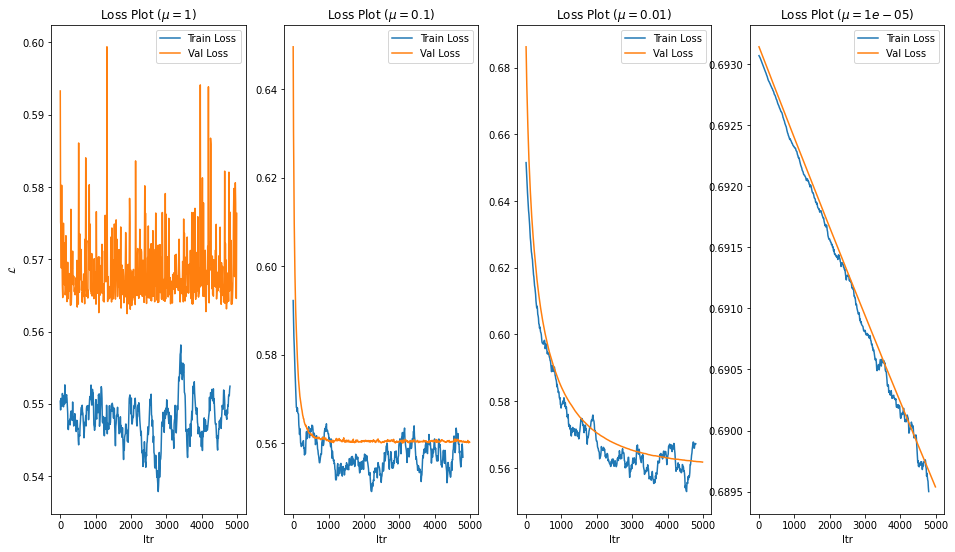

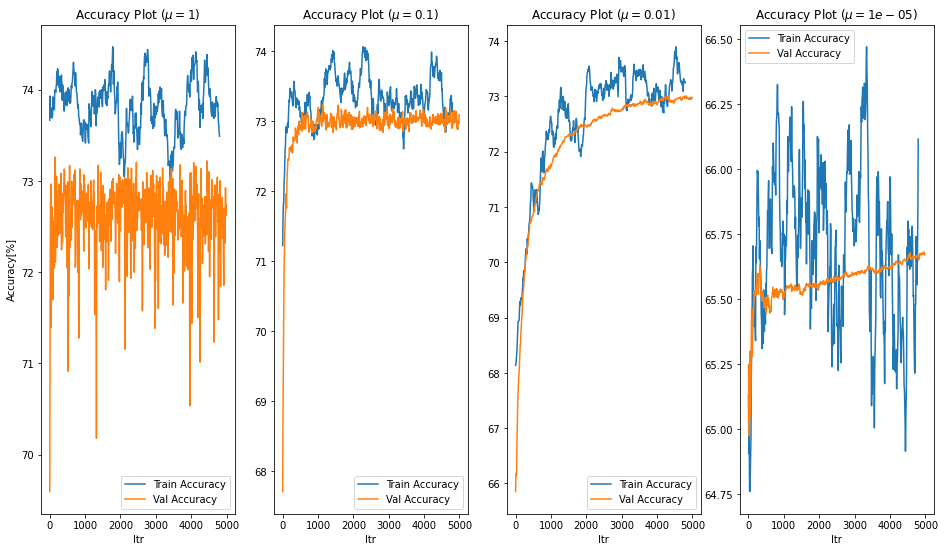

In [90]:
running_avg_size = 20
#Cost Plots
fig, axs = plt.subplots(1, 4,figsize=(16,9))
for i,mu in enumerate(mu_list):
  running_avg_train_loss = np.convolve(res_dict['analysis_dict'][i]['Train_Loss'], np.ones(running_avg_size)/running_avg_size,mode='valid')

  axs[i].plot(range(0,max_itr - (running_avg_size-1)*10,10), running_avg_train_loss)
  axs[i].plot(range(0,max_itr,10),res_dict['analysis_dict'][i]['Val_Loss'])
  axs[i].legend(['Train Loss','Val Loss'])
  axs[i].set_title('Loss Plot ($\mu={}$)'.format(mu))
  axs[i].set_xlabel('Itr')
  if i == 0:
    axs[i].set_ylabel('$\mathcal{L}$')
  
  #ACC Plots
fig, axs = plt.subplots(1, 4,figsize=(16,9))
for i,mu in enumerate(mu_list):
  running_avg_train_acc = np.convolve(res_dict['analysis_dict'][i]['Train_acc'], np.ones(running_avg_size)/running_avg_size,mode='valid')

  axs[i].plot(range(0,max_itr - (running_avg_size-1)*10,10), 100*running_avg_train_acc)
  axs[i].plot(range(0,max_itr,10),100*res_dict['analysis_dict'][i]['Val_acc'])
  axs[i].legend(['Train Accuracy','Val Accuracy'])
  axs[i].set_title('Accuracy Plot ($\mu={}$)'.format(mu))
  axs[i].set_xlabel('Itr')
  if i == 0:
    axs[i].set_ylabel('Accuracy[%]')


**Explain and discuss your results here:**

First, we can see that the results for the train loss and train acc are much noisier than the results for the validation set. That is beacuse we use mini-batch with size of 100 samples in the train step, i.e. we are not using all the train data in each iteartion but a small portion of it, what adds a notion of stochtisity with higer varinces to the results. In the other hand, for the validtion calcultion we used *all* the valdiation dataset, whice yileds some noise reduction.

We can see that the value of the step size has termndeous impcat on the results. When using huge step size of $\mu=1$, we get "jumping" values and we are missing the local minima. From the other hand, when using very small step size of $\mu =10^{5}$, we are not reaching convergence. For the midterme values we get fine results where the best results are achieved by using $\mu=0.01$.



### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

In [91]:
# We will swipe over differnt parmutaion for the hyper-params (init_type,bs,mu)
max_itr = 5000
mu_list = [1,0.1,0.01,1e-5]
batch_size_list = [100,1000,10000]
weight_init = ['zeros','rand']
params_tuples_list = [(init_type, batch_size,mu) for init_type in weight_init
                      for batch_size in batch_size_list
                      for mu in mu_list ]
analysis_dict_list = []

for init_type in weight_init:
  for batch_size in batch_size_list:
    for mu in mu_list:
      print('Init Type: {}, Batch Size: {}, Mu: {}'.format(init_type, batch_size, mu))
      if init_type == 'zeros':
        w0 = np.zeros(90)
        b0 = 0 
      else:
        w0 = np.random.randn(90)
        b0 = np.random.randn(1)[0]

      _, _, analysis_dict = run_gradient_descent(train_norm_xs, train_ts, val_norm_xs,
                                                val_ts.flatten(), w0, b0,
                                                max_iters=max_itr, mu=mu,
                                                batch_size=batch_size, verbose=False)

      analysis_dict_list.append(analysis_dict)

#Find Best Model
best_model_idx = np.argmax([analysis_dict_list[i]['best_acc'] for i in range(len(analysis_dict_list))])
best_b = analysis_dict_list[best_model_idx]['best_b']
best_w = analysis_dict_list[best_model_idx]['best_w']
best_model_best_val_acc = analysis_dict_list[best_model_idx]['best_acc']
print('Best Model: {}, Best Val ACC: {}'.
      format(params_tuples_list[best_model_idx], best_model_best_val_acc ))




Init Type: zeros, Batch Size: 100, Mu: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Iter 1250. [Train Loss 0.467112, Val Loss 0.610984, Train Acc 81%, Val Acc 72%]
Iter 2500. [Train Loss 0.409116, Val Loss 0.624957, Train Acc 84%, Val Acc 71%]
Iter 3750. [Train Loss 0.311799, Val Loss 0.628992, Train Acc 92%, Val Acc 71%]
Iter 5000. [Train Loss 0.448772, Val Loss 0.628964, Train Acc 79%, Val Acc 70%]
Init Type: zeros, Batch Size: 100, Mu: 0.1
Iter 1250. [Train Loss 0.530077, Val Loss 0.564444, Train Acc 76%, Val Acc 73%]
Iter 2500. [Train Loss 0.473482, Val Loss 0.566335, Train Acc 81%, Val Acc 72%]
Iter 3750. [Train Loss 0.470117, Val Loss 0.566112, Train Acc 76%, Val Acc 72%]
Iter 5000. [Train Loss 0.624620, Val Loss 0.565131, Train Acc 69%, Val Acc 73%]
Init Type: zeros, Batch Size: 100, Mu: 0.01
Iter 1250. [Train Loss 0.579767, Val Loss 0.579585, Train Acc 75%, Val Acc 72%]
Iter 2500. [Train Loss 0.574393, Val Loss 0.567896, Train Acc 67%, Val Acc 73%]
Iter 3750. [Train Loss 0.585573, Val Loss 0.563806, Train Acc 72%, Val Acc 73%]
Iter 5000. [Train Loss 0.511715, 

In [177]:
#We will sort by the bes val_acc values for each model

acc_best_vals_arr = [analysis_dict_list[i]['best_acc'] for i in range(len(analysis_dict_list))]
sorted_idxs = np.argsort([-analysis_dict_list[i]['best_acc'] for i in range(len(analysis_dict_list))])
acc_val_sorted = [(acc_best_vals_arr[idx],params_tuples_list[idx],idx) for idx in sorted_idxs]
print(acc_val_sorted)
params_tuples_list_sorted = [params_tuples_list[i] for i in sorted_idxs]

def Loss_Acc_Plots(idx,supTitle, params_tuples_list,analysis_dict_list,running_avg_size=20,max_itr=5000):
  """ Plot function for Loss and ACC values for a given model idx"""
  init_type, batch_size, mu = params_tuples_list[idx]
  fig, axs = plt.subplots(1, 2,figsize=(16,9))
  fig.suptitle(supTitle, fontsize=16)

  running_avg_train_loss = np.convolve(analysis_dict_list[idx]['Train_Loss'],
                                      np.ones(running_avg_size)/running_avg_size,mode='valid')
  axs[0].plot(range(0,max_itr - (running_avg_size-1)*10,10), running_avg_train_loss)
  axs[0].plot(range(0,max_itr,10),analysis_dict_list[idx]['Val_Loss'])
  axs[0].legend(['Train Loss','Val Loss'])
  axs[0].set_title('Loss Plot ($Init Type: {}, BS: {}, \mu={}$)'.format(init_type, batch_size, mu))
  axs[0].set_xlabel('Itr')
  axs[0].set_ylabel('$\mathcal{L}$')

  running_avg_train_acc = np.convolve(analysis_dict_list[idx]['Train_acc'], np.ones(running_avg_size)/running_avg_size,mode='valid')

  axs[1].plot(range(0,max_itr - (running_avg_size-1)*10,10), 100*running_avg_train_acc)
  axs[1].plot(range(0,max_itr,10),100*analysis_dict_list[idx]['Val_acc'])
  axs[1].legend(['Train Accuracy','Val Accuracy'])
  axs[1].set_title('Accuracy Plot ($Init Type: {}, BS: {}, \mu={}$)'.format(init_type, batch_size, mu))
  axs[1].set_xlabel('Itr')
  axs[1].set_ylabel('Accuracy[%]')



[(0.73362, ('rand', 1000, 1), 16), (0.73314, ('zeros', 10000, 1), 8), (0.73252, ('zeros', 1000, 1), 4), (0.73242, ('rand', 10000, 1), 20), (0.73222, ('rand', 1000, 0.1), 17), (0.73212, ('zeros', 1000, 0.1), 5), (0.73212, ('rand', 100, 0.1), 13), (0.73188, ('zeros', 100, 0.1), 1), (0.7312, ('zeros', 10000, 0.1), 9), (0.73108, ('rand', 10000, 0.1), 21), (0.73018, ('zeros', 100, 0.01), 2), (0.7299, ('zeros', 1000, 0.01), 6), (0.7296, ('zeros', 10000, 0.01), 10), (0.72048, ('zeros', 100, 1), 0), (0.71958, ('rand', 100, 1), 12), (0.70522, ('rand', 100, 0.01), 14), (0.70042, ('rand', 1000, 0.01), 18), (0.68558, ('rand', 10000, 0.01), 22), (0.66004, ('zeros', 100, 1e-05), 3), (0.65686, ('zeros', 1000, 1e-05), 7), (0.65684, ('zeros', 10000, 1e-05), 11), (0.5501, ('rand', 1000, 1e-05), 19), (0.52562, ('rand', 10000, 1e-05), 23), (0.50452, ('rand', 100, 1e-05), 15)]


We will generage some examples for good and bad models:

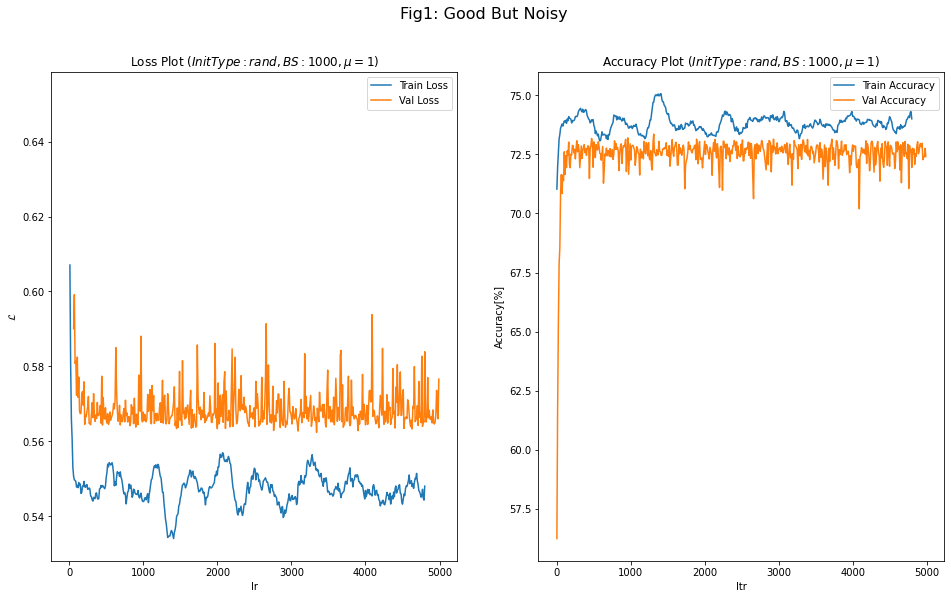

In [182]:
#Good but "noisy"
Loss_Acc_Plots(idx=16, supTitle='Fig1: Good But Noisy', params_tuples_list=params_tuples_list,analysis_dict_list=analysis_dict_list)


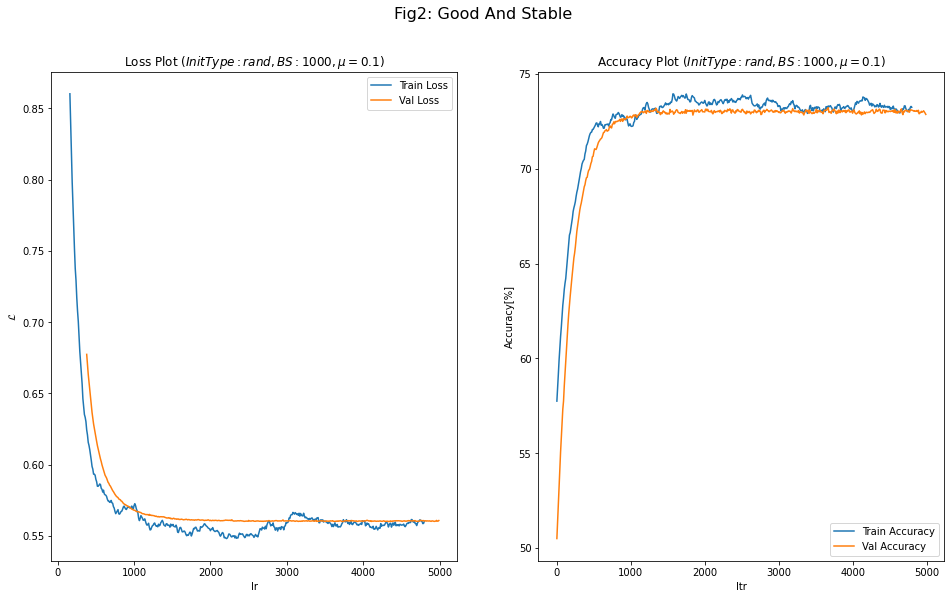

In [183]:
#Good but and stable
Loss_Acc_Plots(idx=17, supTitle='Fig2: Good And Stable', params_tuples_list=params_tuples_list,analysis_dict_list=analysis_dict_list)


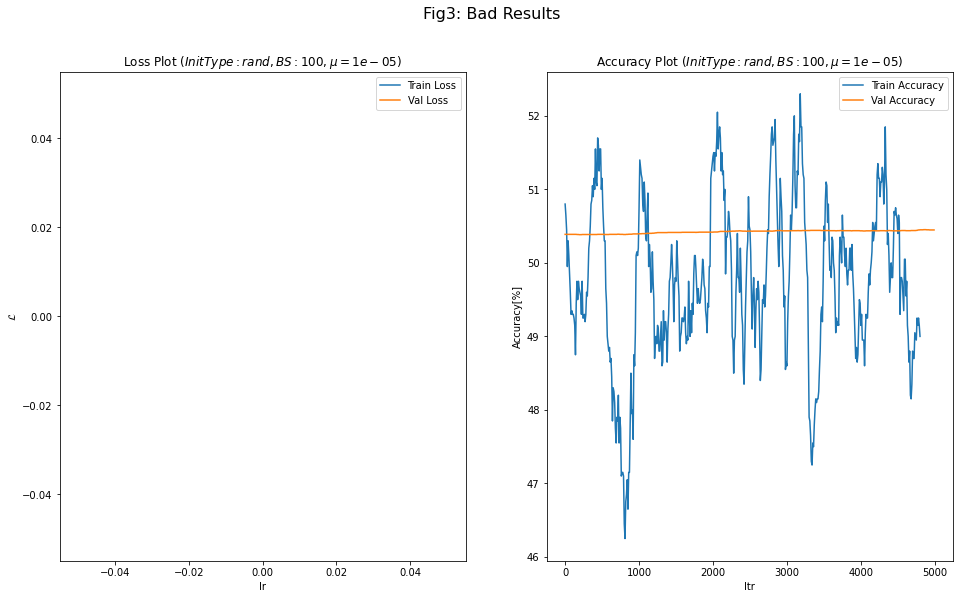

In [186]:
#Bad Results
Loss_Acc_Plots(idx=15, supTitle='Fig3: Bad Results', params_tuples_list=params_tuples_list,analysis_dict_list=analysis_dict_list)


**Explain and discuss your results here:**

In Figures 1-3 we can see different results for different hyper-params. In Figure 1 we can see that although we got the highest acc_val of 0.73362 we got noisy loss and acc plots, that is due to the large step size of $\mu=1$, we will preferer to take as best result the hyper params that will yield similar acc_val but with more stable plots. Therefore we choose as best model the one shown in Figure 2 that achieved very close best acc of 0.73222 and more stable plots we the values of:

```
mu = 0.1, batch_size = 1000, init_type = 'rand'
```
In Figure 3 we can see very bad results when we used small step size μ=1e−5, we can see no values on the loss plots because all the values are nan (we got zero or negative values in the log argument), the values for the acc plot are also very bad.






### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [187]:
# Write your code here
best_idx = 17
best_b = analysis_dict_list[best_idx]['best_b']
best_w = analysis_dict_list[best_idx]['best_w']

pred_val = pred(best_w, best_b, val_norm_xs)
pred_train = pred(best_w, best_b, train_norm_xs)
pred_test = pred(best_w, best_b, test_norm_xs)

train_acc = get_accuracy(pred_train, train_ts)
val_acc = get_accuracy(pred_val, val_ts)
test_acc = get_accuracy(pred_test, test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  0.7337152387513143  val_acc =  0.73222  test_acc =  0.7277358125121054


**Explain and discuss your results here:**

We can see the acc results for each set is different. Although the values are different, they close enough to each other in a reasonable sense. The best result was achieved to the train set because those are the values we trained on. The next best value is for the validation set because the validation set has the same distribution as the train set. The test set is a different set from the train (and so from the validation) as was explained in the "producer effect" and thats why it has the lowest value. Although the test acc is the lowest, it is still close enough to the validation results which indicates that we are not overfitted.


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [ ]:
import sklearn.linear_model

model = ...

train_acc = ...
val_acc = ...
test_acc = ...

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
